<div style="color: #ffffff; background-color: #2979ff; border-bottom: 1px solid #004ecb; padding: 2em;">
<b style="font-size: 20pt;">ILLUIN TECHNOLOGY</b>
    
<b style="font-size: 20pt;">Détection d'intention dans un chatbot</b> <br> <br>
<b style="font-size: 14pt;">Andy Zhang</b>
</div>

Ce Notebook contient une première solution au problème proposé, en utilisant des algorithmes classiques de machine learning et en particulier des algorithmes classiques de classification.

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # To display all the text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from utils import map_class_to_int, complete_eval, print_metrics, single_prediction, display_all_results

<div>
<b style="font-size: 20pt;">DATA PRE-PROCESSING</b>
</div>

In [2]:
# Load the data
data = pd.read_csv('../data/intent-detection-train.csv')

In [3]:
data.sample(n=10)

,text,label
278,Est-ce que mes bagages ont été égarés pendant le trajet en voiture de location?,lost_luggage
135,Quelles sont les conditions actuelles dans ce pays en ce qui concerne les voyages?,travel_alert
356,Je cherche des détails sur les règles pour les bagages à main en cabine.,carry_on
309,"Je suis à la recherche de voyages uniques, pouvez-vous me conseiller?",travel_suggestion
434,Je souhaite trouver un moyen de transport aérien pour mon voyage à venir.,book_flight
143,Quels sont les conseils pour les voyageurs se rendant dans ce pays?,travel_alert
17,Quand vais-je arriver à destination,flight_status
214,Je souhaite obtenir des informations sur mon voyage en avion.,flight_status
19,Perte des bagages sur Flight America Airlines à O'Hare,lost_luggage
499,"J'ai des problèmes de gestion du temps, que devrais-je faire?",out_of_scope


<Figure size 1152x1296 with 0 Axes>

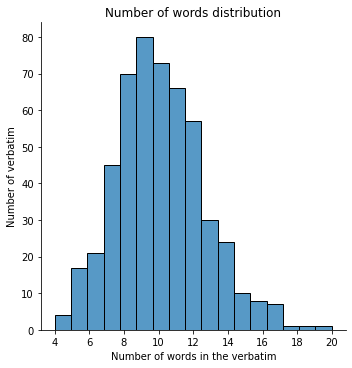

In [4]:
# Affichage de la distribution des longueurs des verbatim
data['length'] = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize = (16, 18))
sns.displot(data['length'])
plt.title('Number of words distribution')
plt.xlabel('Number of words in the verbatim')
plt.ylabel('Number of verbatim')
plt.savefig('../docs/data_word_length_distribution.jpg', bbox_inches='tight', dpi=300)
plt.show()

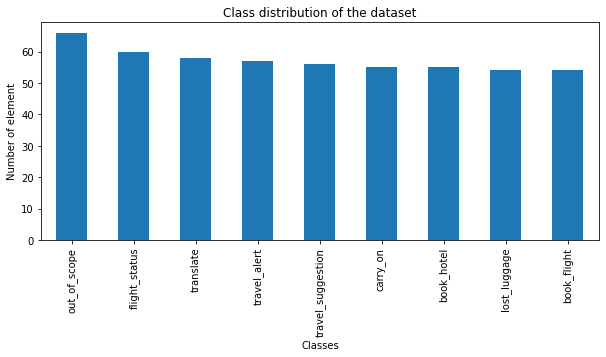

In [5]:
# Affichage de la répartition des classes pour observer la distribution des données
plt.figure(figsize = (10, 4))
data['label'].value_counts().plot(kind='bar')
plt.title('Class distribution of the dataset')
plt.xlabel('Classes')
plt.ylabel('Number of element')
plt.savefig('../docs/class_distribution.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [6]:
# Construct a mapping between the class names and a unique id
class_names = data.label.unique()
class_name_to_label, label_to_class_name = map_class_to_int(class_names)

In [7]:
# Transform the data in order to be used in a classification model
text_data = data.text.values.copy()
data_label = data.label.copy()
for i in range(len(data_label)):
    data_label[i] = class_name_to_label[data_label[i]]
data_label = data_label.astype(int)

In [8]:
# Perform word embedding on the text data based on term frequency and inverse document frequency
tfidf_vectorizer = TfidfVectorizer()
tfidf_data = tfidf_vectorizer.fit_transform(text_data)

In [9]:
# Split the data into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(tfidf_data, data_label, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=data_label)

In [10]:
print("Training set shape :", X_train.shape)
print("Test set shape :", X_test.shape)

Training set shape : (412, 728)
Test set shape : (103, 728)


<div>
<b style="font-size: 20pt;">MODEL BUILDING</b>
</div>

<div>
<b style="font-size: 16pt;">LOGISTIC REGRESSION</b>
</div>

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression() 

param_grid_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train, y_train)

/home/andy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/andy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:35

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [12]:
best_params_log_reg = grid_search_log_reg.best_params_
best_model_log_reg = grid_search_log_reg.best_estimator_
print(best_params_log_reg)

{'C': 100, 'penalty': 'l2', 'solver': 'saga'}


Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-score: 0.91
                   precision    recall  f1-score   support

        translate       1.00      1.00      1.00        12
     travel_alert       0.91      0.91      0.91        11
    flight_status       0.92      1.00      0.96        12
     lost_luggage       1.00      1.00      1.00        11
travel_suggestion       0.86      0.55      0.67        11
         carry_on       1.00      1.00      1.00        11
       book_hotel       0.79      1.00      0.88        11
      book_flight       0.91      0.91      0.91        11
     out_of_scope       0.85      0.85      0.85        13

         accuracy                           0.91       103
        macro avg       0.91      0.91      0.91       103
     weighted avg       0.91      0.91      0.91       103



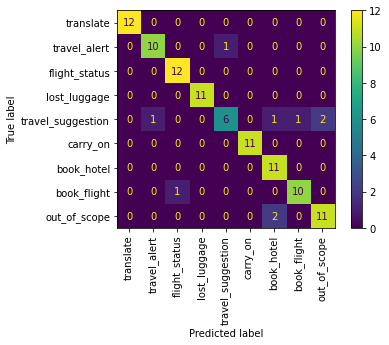

In [13]:
display_all_results(best_model_log_reg, X_test, y_test, class_names)

In [14]:
test_text = "je peux prendre mon ordinateur avec moi dans l'avion ?"
single_prediction(test_text, best_model_log_reg, label_to_class_name, tfidf_vectorizer)

'carry_on'

<div>
<b style="font-size: 16pt;">RANDOM FOREST</b>
</div>

In [15]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

param_grid_random_forest = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': [None, 'sqrt']
}

grid_search_random_forest = GridSearchCV(random_forest, param_grid_random_forest, cv=5, scoring='accuracy')
grid_search_random_forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [16]:
best_params_random_forest = grid_search_random_forest.best_params_
best_model_random_forest = grid_search_random_forest.best_estimator_
print(best_params_random_forest)

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


Accuracy: 0.88
Precision: 0.91
Recall: 0.88
F1-score: 0.88
                   precision    recall  f1-score   support

        translate       0.92      1.00      0.96        12
     travel_alert       0.75      0.82      0.78        11
    flight_status       0.86      1.00      0.92        12
     lost_luggage       1.00      1.00      1.00        11
travel_suggestion       1.00      0.55      0.71        11
         carry_on       1.00      1.00      1.00        11
       book_hotel       0.90      0.82      0.86        11
      book_flight       1.00      0.73      0.84        11
     out_of_scope       0.72      1.00      0.84        13

         accuracy                           0.88       103
        macro avg       0.91      0.88      0.88       103
     weighted avg       0.90      0.88      0.88       103



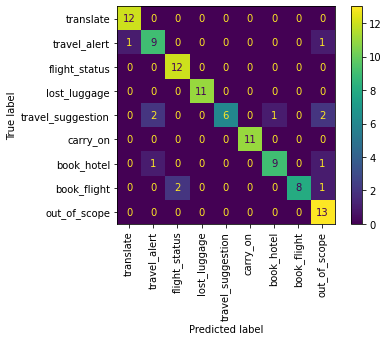

In [17]:
display_all_results(best_model_random_forest, X_test, y_test, class_names)

In [18]:
test_text ="mes valises sont où?"
single_prediction(test_text, best_model_random_forest, label_to_class_name, tfidf_vectorizer)

'lost_luggage'

<div>
<b style="font-size: 16pt;">K-NN : K-Nearest Neighboor</b>
</div>

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid_knn = {'n_neighbors': range(2, 15)}

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 15)}, scoring='accuracy')

In [20]:
best_params_knn = grid_search_knn.best_params_
best_model_knn = grid_search_knn.best_estimator_
print(best_params_knn)

{'n_neighbors': 3}


Accuracy: 0.80
Precision: 0.81
Recall: 0.80
F1-score: 0.79
                   precision    recall  f1-score   support

        translate       0.80      1.00      0.89        12
     travel_alert       1.00      0.73      0.84        11
    flight_status       0.71      1.00      0.83        12
     lost_luggage       0.91      0.91      0.91        11
travel_suggestion       0.70      0.64      0.67        11
         carry_on       1.00      1.00      1.00        11
       book_hotel       0.70      0.64      0.67        11
      book_flight       0.69      0.82      0.75        11
     out_of_scope       0.75      0.46      0.57        13

         accuracy                           0.80       103
        macro avg       0.81      0.80      0.79       103
     weighted avg       0.80      0.80      0.79       103



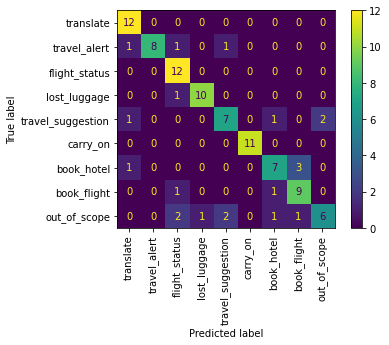

In [21]:
display_all_results(best_model_knn, X_test, y_test, class_names)

In [22]:
test_text ="tu penses quoi du modèle KNN pour classifier des documents ?"
single_prediction(test_text, best_model_knn, label_to_class_name, tfidf_vectorizer)

'out_of_scope'

<div>
<b style="font-size: 16pt;">SVC : Support Vector Classifier </b>
</div>

In [23]:
from sklearn.svm import SVC

svc = SVC()

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'decision_function_shape': ['ovo', 'ovr']
}

grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'degree': [2, 3, 4], 'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [24]:
best_params_svc = grid_search_svc.best_params_
best_model_svc = grid_search_svc.best_estimator_
print(best_params_svc)

{'C': 10, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


Accuracy: 0.91
Precision: 0.92
Recall: 0.91
F1-score: 0.91
                   precision    recall  f1-score   support

        translate       1.00      1.00      1.00        12
     travel_alert       0.91      0.91      0.91        11
    flight_status       0.92      1.00      0.96        12
     lost_luggage       1.00      1.00      1.00        11
travel_suggestion       0.86      0.55      0.67        11
         carry_on       1.00      1.00      1.00        11
       book_hotel       0.91      0.91      0.91        11
      book_flight       1.00      0.91      0.95        11
     out_of_scope       0.71      0.92      0.80        13

         accuracy                           0.91       103
        macro avg       0.92      0.91      0.91       103
     weighted avg       0.92      0.91      0.91       103



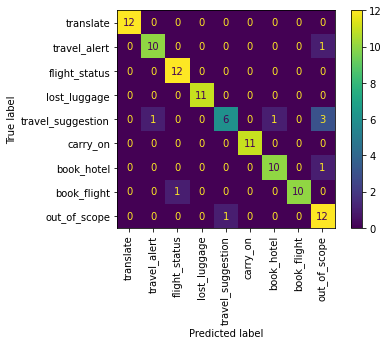

In [25]:
display_all_results(best_model_svc, X_test, y_test, class_names)

In [26]:
test_text ="j'aimerai bien aller en corée du sud"
single_prediction(test_text, best_model_svc, label_to_class_name, tfidf_vectorizer)

'travel_suggestion'

Au vu des différents résultats obtenus pour les différents algorithmes qui ont été testés, le modèles qui semblent être le plus performants est le $\textbf{SVM}$. 

Une attention particulière a été porté sur la classe $\texttt{lost}$_$\texttt{luggage}$. Et en particulier sur la métrique False Positive Rate, qui doit être le plus petit possible car dans le cas contraire, les faux positifs sur cette classe redirigerait vers un service client qui a des conseillers téléphoniques ayant un coût élevé.